In [1]:
%matplotlib inline

import os
import glob

import numpy as np
import pandas as pd

from astropy.io import fits
from astropy.table import Table

from desispec.interpolation import resample_flux

from collections import Counter

import matplotlib as mpl
from matplotlib import pyplot as plt

mpl.rc('font', family='serif', size=16)

In [5]:
# Load in the data
basedir = '/Users/ryanrubenzahl/Documents/DESI/my_outlier_detection/'
specdir = 'galaxy_sim_catalog/spectra/'
expid = 4

fluxscaled_sne = ['bright_atpeak', 'dim_atpeak', 
                  'faint_atpeak', 'very_faint_atpeak']

scaled_files = {}
for sn_dir in fluxscaled_sne:
             
    gal_globpath = basedir + specdir + 'galaxies/*expid%03d*.fits' % expid
    sn_globpath  = basedir + specdir + sn_dir + '/*expid%03d*.fits'% expid

    # Galaxies without supernovae
    gal_files = glob.glob(gal_globpath)
    # Galaxies with supernovae
    sn_host_files = glob.glob(sn_globpath)

    scaled_files[sn_dir] = {'galaxies': gal_files,
                            'sn_hosts': sn_host_files}

for sn_dir in scaled_files:
    
    print sn_dir
    print len(scaled_files[sn_dir]['galaxies']), "total galaxies"
    print len(scaled_files[sn_dir]['sn_hosts']), "total sn hosts"
    print

bright_atpeak
21000 total galaxies
18900 total sn hosts

dim_atpeak
21000 total galaxies
18900 total sn hosts

very_faint_atpeak
21000 total galaxies
18900 total sn hosts

faint_atpeak
21000 total galaxies
18900 total sn hosts



## Read in the data to an astropy table

In [7]:
spec_tables = {}

for sn_dir in scaled_files:
    gal_files     = scaled_files[sn_dir]['galaxies']
    sn_host_files = scaled_files[sn_dir]['sn_hosts']
    all_files = np.append(gal_files, sn_host_files)
    
    data = []

    for n, f in enumerate(all_files):

        # Read the fits file
        with fits.open(f, memmap=0) as hdul:

            specid  = os.path.basename(f)[8:31] # Spectra ID tag
            objtype = hdul[0].header['OBJTYPE'] # Object type (e.g. BGS)

            # Throw out non-galaxy types (sky/calib star)
            if objtype in ['SKY', 'FSTD']:
                continue
            else:
                has_sn  = hdul[0].header['HAS_SN'] # SN or not
                Z    = hdul[0].header['REDSHIFT']  # z of the spectrum
                mag  = hdul[0].header['MAG']       # m of host galaxy
                wave = hdul[1].data / (Z+1) # wavelength in rest frame
                if not has_sn:
                    flux = hdul[2].data * 1e-17 # match flux units
                    sn_epoch = np.nan           # if empty epoch
                else:
                    flux = hdul[2].data         # flux values
                    sn_epoch = hdul[0].header['SN_EPOCH'] # SN epoch
                ivar = hdul[3].data # inverse variance (in the flux)
                # TODO: FIX IVAR UNIT HERE

                # Create a new table row
                new_row = [specid, objtype, has_sn, sn_epoch, 
                           Z, mag, wave, flux, ivar]

                # And add it to the table
                data.append(new_row)

    spec_df = pd.DataFrame(data=data, 
                          columns=('ID', 'OBJTYPE', 'HAS_SN', 'SN_EPOCH', 
                              'REDSHIFT', 'MAG', 'WAVE', 'FLUX', 'IVAR'))
    spec_table = Table.from_pandas(spec_df)
    
    spec_tables[sn_dir] = spec_table

## Eigenspectra Analysis

In [8]:
# Read in the eigenbasis
eigentable = np.genfromtxt(basedir + 'galaxy_sim_catalog/eigenspectra.txt')

global_wavelength_grid = eigentable[0]
eigenspectra = eigentable[1:]

In [11]:
# Resample spectra to a common wavelength grid
for sn_dir in spec_tables:
    spec_table = spec_tables[sn_dir]
    
    resample_fluxes = []
    resample_ivars  = []
    for spectra in spec_table:
        spec_flux_resample, spec_ivar_resample = resample_flux(
                                 global_wavelength_grid, 
                                 spectra['WAVE'], 
                                 spectra['FLUX'],
                                 ivar=spectra['IVAR'], 
                                 extrapolate=False
                                )
        resample_fluxes.append(spec_flux_resample)
        resample_ivars.append(spec_ivar_resample)

    spec_table['RESAMPLED_FLUX'] = resample_fluxes
    spec_table['RESAMPLED_IVAR'] = resample_ivars

In [7]:
# Loop through the spectra and calculate the
# continuum flux using an eigenspectra fit
for sn_dir in spec_tables:
    spec_table = spec_tables[sn_dir]
    
    continuum_fluxes = []
    for spectra in spec_table:    
        # Project/fit the basis to the spectrum
        basis_fit     = np.dot(np.linalg.pinv(eigenspectra.T), 
                               spectra['RESAMPLED_FLUX'])
        bestfit_flux  = np.dot(basis_fit, eigenspectra)

        continuum_fluxes.append(bestfit_flux)

    spec_table['CONTINUUM_FLUX'] = continuum_fluxes

## Measure amplitudes of features

Table of feature boundaries in type Ia supernova spectra

from https://arxiv.org/pdf/1011.6227.pdf

| Feature | Dominating line | Lower region (centre A) | Upper region (centre A) | Rest wavelength (A) |
|---------||----------------|-------------------------||---------------|
|f1 | Ca II H&K           | 3450 - 3800 | 3800 - 4100 | 3945.12 |
|f2 | Si II $\lambda$4000 | 3800 - 3950 | 4000 - 4200 | 4129.73 |
|f3 | Mg II $\lambda$4300 | 3850 - 4250 | 4300 - 4700 | 4481.20 |
|f4 | Fe II $\lambda$4800 | 4300 - 4700 | 4950 - 5600 | 5083.42 |
|f5 | S II W              | 5050 - 5300 | 5500 - 5750 | 5536.24 |
|f6 | Si II $\lambda$5800 | 5400 - 5700 | 5800 - 6000 | 6007.70 |
|f7 | Si II $\lambda$6150 | 5800 - 6100 | 6200 - 6600 | 6355.21 |

In [12]:
features = {
#   id     center    lower region    upper region
    "f1": [3800, [3450, 3800], [3800, 4000]],
    "f2": [4000, [3900, 3950], [4050, 4200]],
    "f3": [4300, [4000, 4250], [4300, 4700]],
    "f4": [4800, [4300, 4700], [4950, 5600]],
    "f5": [5475, [5050, 5300], [5500, 5750]],
    "f6": [5800, [5400, 5700], [5800, 6000]],
    "f7": [6150, [5900, 6100], [6200, 6500]],
}
# features = {
# #   id     center    min    max
#     "f1": [3800, 3700, 3900],
#     "f2": [4000, 3950, 4100],
#     "f3": [4300, 4200, 4400],
#     "f4": [4850, 4700, 5000],
#     "f5": [5475, 5400, 5550],
#     "f6": [5800, 5750, 5850],
#     "f7": [6150, 6000, 6300],
# }
featurenames = {
#   id     center    min    max
    "f1": "Ca II H&K",
    "f2": "Si II $\lambda$4000",
    "f3": "Mg II $\lambda$4300",
    "f4": "Fe II $\lambda$4800",
    "f5": "S II W",
    "f6": "Si II $\lambda$5800",
    "f7": "Si II $\lambda$6150",
}

In [15]:
def lowPassFilter(signal, fc, b):
    N = int(np.ceil((4 / b)))
    if not N % 2:
        N += 1
    n = np.arange(N)
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    w1 = 0.42 - 0.5 * np.cos(2 * np.pi * n / (N - 1))
    window = w1 + 0.08 * np.cos(4 * np.pi * n / (N - 1))
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)
    return N, np.convolve(signal, sinc_func)

def highPassFilter(signal, fc, b):
    N = int(np.ceil((4 / b)))
    if not N % 2:
        N += 1
    n = np.arange(N)
 
    sinc_func = np.sinc(2 * fc * (n - (N - 1) / 2.))
    window = np.blackman(N)
    sinc_func = sinc_func * window
    sinc_func = sinc_func / np.sum(sinc_func)

    # reverse function
    sinc_func = -sinc_func
    sinc_func[(N - 1) // 2] += 1

    return N, np.convolve(signal, sinc_func)

In [16]:
def get_feature_box(feature, spectrum):
    
    flux = spectrum['RESAMPLED_FLUX'] 
    lowercut = ((global_wavelength_grid > feature[1][0]) &
                    (global_wavelength_grid < feature[1][1]))
    uppercut = ((global_wavelength_grid > feature[2][0]) &
                    (global_wavelength_grid < feature[2][1]))
    
    lowerregion = global_wavelength_grid[lowercut]
    upperregion = global_wavelength_grid[uppercut]
    
#     lowerregion_flux = flux[lowercut]
#     upperregion_flux = flux[uppercut]
    
    # Using low pass filters
    fc, b = 0.01, 0.01
    N, lpf = lowPassFilter(flux, fc=fc, b=b)
    dN = (N-1) // 2
    lpf = lpf[dN:-dN]
    
    lowerregion_flux = lpf[lowercut]
    upperregion_flux = lpf[uppercut]

    lowerbound = lowerregion[np.argmax(lowerregion_flux)]
    upperbound = upperregion[np.argmax(upperregion_flux)]
        
    featurecut = ((global_wavelength_grid > lowerbound) &
                    (global_wavelength_grid < upperbound))
    
    feature_wave = global_wavelength_grid[featurecut]
    feature_flux = lpf[featurecut] # flux[featurecut]
    
    # Define the pseudo-continuum
    fluxdiff = (feature_flux[-1] - feature_flux[0])
    waverange = (upperbound - lowerbound)
    slope = fluxdiff / waverange
    
    pseudo_continuum = feature_flux[0]+slope*(feature_wave-lowerbound)

    return [feature_wave, feature_flux, pseudo_continuum], lpf



In [17]:
def get_pEW(feature, spectrum):
    
    # Get the bounding box to calculate the pEW in
    feature_box, lpf = get_feature_box(feature, spectrum)
    feature_wave, feature_flux, pseudo_continuum = feature_box
    
    pEW = np.sum(1. - feature_flux/pseudo_continuum)    
    
    return pEW

In [18]:
for sn_dir in spec_tables:
    spec_table = spec_tables[sn_dir]
    
    pEW_features = []
    for spectrum in spec_table:
        pEWs = []
        gaussian_amplitudes = []
        for fn in sorted(features.keys()):
            feature = features[fn]
            pEW = get_pEW(feature, spectrum)
            pEWs.append(pEW)

        pEW_features.append(pEWs)

    spec_table['pEW_FEATURES'] = pEW_features


## Organize data for classification

In [19]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

In [20]:
datatables = {}

for sn_dir in spec_tables:
    spec_table = spec_tables[sn_dir]
    
    # Load feature values into one overall table
    # each column = one feature
    table  = []
    names  = []
    dtypes = []

    num_features = len(features)

    for spec in spec_table:
        tablerow = np.append(spec['pEW_FEATURES'], spec['HAS_SN'])
        table.append(tablerow)

    for i in range(1,num_features+1):
        names.append("f%d" % i)
        dtypes.append(np.float32)

    names.append('HAS_SN')
    dtypes.append('S')

    data = Table(rows=table, names=names, dtype=dtypes)
    
    datatables[sn_dir] = data

## Run random forest classifier on featureset

In [23]:
rf_classifiers = {}
predictions = {}
actuals     = {}

for sn_dir in datatables:
    print sn_dir
    
    data = datatables[sn_dir]
    
    df = data.to_pandas()

    df['is_train'] = np.random.uniform(0, 1, len(df)) <= 0.75

    # We now split the dataframes into a test and training dataset
    train, test = df[df['is_train']==True], df[df['is_train']==False]
    print 'Number of observations in the training data:', len(train)
    print 'Number of observations in the test data:',len(test)

    train_count = Counter(train['HAS_SN'])
    test_count  = Counter(test['HAS_SN'])

    trainstr = ""
    for k in train_count.keys():
        trainstr += "%s %d," % (k, train_count[k])
    print "Training set: %d: (%s)" % (len(train), trainstr)

    teststr = ""
    for k in test_count.keys():
        teststr += "%s %d," % (k, test_count[k])
    print "Training set: %d: (%s)" % (len(test), teststr)

    rf_features = df.columns[:-2]
    rf_features

    y, objtypes = pd.factorize(train['HAS_SN'])

    # Now we train the random forest
    clf = RandomForestClassifier(n_jobs=1, 
                                 random_state=0,
                                 verbose=0)

    clf.fit(train[rf_features], y)

    rf_classifiers[sn_dir] = clf
    
    # Apply the classifier to the test data
    preds = [objtypes[i] for i in clf.predict(test[rf_features])]
    
    predictions[sn_dir] = preds
    actuals[sn_dir] = np.asarray(test['HAS_SN'])
    
    print

bright_atpeak
Number of observations in the training data: 28386
Number of observations in the test data: 9414
Training set: 28386: (Ia 14227,0.0 14159,)
Training set: 9414: (Ia 4673,0.0 4741,)

dim_atpeak
Number of observations in the training data: 28279
Number of observations in the test data: 9521
Training set: 28279: (Ia 14079,0.0 14200,)
Training set: 9521: (Ia 4821,0.0 4700,)

very_faint_atpeak
Number of observations in the training data: 28404
Number of observations in the test data: 9396
Training set: 28404: (Ia 14194,0.0 14210,)
Training set: 9396: (Ia 4706,0.0 4690,)

faint_atpeak
Number of observations in the training data: 28256
Number of observations in the test data: 9544
Training set: 28256: (Ia 14125,0.0 14131,)
Training set: 9544: (Ia 4775,0.0 4769,)



In [26]:
from pandas_ml import ConfusionMatrix

cm = ConfusionMatrix(actuals['bright_atpeak'], 
                     predictions['bright_atpeak'])
cm.print_stats()

population: 9414
P: 4673
N: 4741
PositiveTest: 4674
NegativeTest: 4740
TP: 4673
TN: 4740
FP: 1
FN: 0
TPR: 1.0
TNR: 0.999789074035
PPV: 0.999786050492
NPV: 1.0
FPR: 0.000210925964986
FDR: 0.000213949507916
FNR: 0.0
ACC: 0.999893775228
F1_score: 0.999893013801
MCC: 0.999787562262
informedness: 0.999789074035
markedness: 0.999786050492
prevalence: 0.496388357765
LRP: 4741.0
LRN: 0.0
DOR: inf
FOR: 0.0


In [59]:
# Display how well the classifier did via a confusion matrix
ratio_stats = []
for sn_dir in fluxscaled_sne:
    print sn_dir
    cm = ConfusionMatrix(actuals[sn_dir], 
                     predictions[sn_dir])
    ratio_stats.append(cm)
    print cm
    print

bright_atpeak
Predicted   0.0    Ia  __all__
Actual                        
0.0        4740     1     4741
Ia            0  4673     4673
__all__    4740  4674     9414

dim_atpeak
Predicted   0.0    Ia  __all__
Actual                        
0.0        4699     1     4700
Ia            3  4818     4821
__all__    4702  4819     9521

faint_atpeak
Predicted   0.0    Ia  __all__
Actual                        
0.0        4550   219     4769
Ia          256  4519     4775
__all__    4806  4738     9544

very_faint_atpeak
Predicted   0.0    Ia  __all__
Actual                        
0.0        2702  1988     4690
Ia         2774  1932     4706
__all__    5476  3920     9396



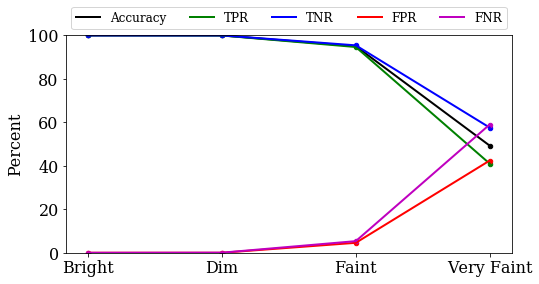

In [69]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

labels = ['Bright', 'Dim', 'Faint', 'Very Faint']

ratio_acc = np.array([cm.ACC for cm in ratio_stats])
ratio_TPR = np.array([cm.TPR for cm in ratio_stats])
ratio_TNR = np.array([cm.TNR for cm in ratio_stats])
ratio_FPR = np.array([cm.FPR for cm in ratio_stats])
ratio_FNR = np.array([cm.FNR for cm in ratio_stats])

ax.plot(range(len(fluxscaled_sne)), ratio_acc*100, 
            color='k', lw=2, label='Accuracy')
ax.scatter(range(len(fluxscaled_sne)), ratio_acc*100, color='k', s=20)

ax.plot(range(len(fluxscaled_sne)), ratio_TPR*100, 
            color='g', lw=2, label='TPR')
ax.scatter(range(len(fluxscaled_sne)), ratio_TPR*100, color='g', s=20)

ax.plot(range(len(fluxscaled_sne)), ratio_TNR*100, 
            color='b', lw=2, label='TNR')
ax.scatter(range(len(fluxscaled_sne)), ratio_TNR*100, color='b', s=20)

ax.plot(range(len(fluxscaled_sne)), ratio_FPR*100, 
            color='r', lw=2, label='FPR')
ax.scatter(range(len(fluxscaled_sne)), ratio_FPR*100, color='r', s=20)

ax.plot(range(len(fluxscaled_sne)), ratio_FNR*100, 
            color='m', lw=2, label='FNR')
ax.scatter(range(len(fluxscaled_sne)), ratio_FNR*100, color='m', s=20)


# Lables and stuff
ax.set(ylabel='Percent', ylim=[0,100],
       xticks=range(len(fluxscaled_sne)), xticklabels=labels)

ax.legend(loc='center', bbox_to_anchor=(0.5, 1.08), ncol=5, fontsize=12)
# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

savedir = '/Users/ryanrubenzahl/Library/Ryan/College/Senior Thesis/'
savedir += 'thesis/Figures/'

# plt.savefig(savedir + 'ratioscaling_stats.png',
#            format='png', dpi=300, bbox_inches='tight')

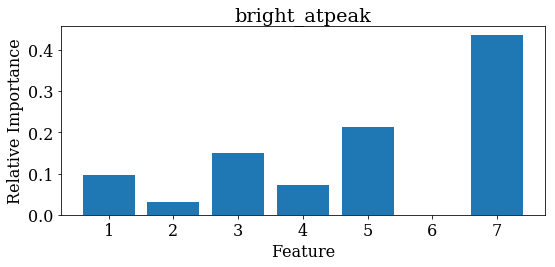

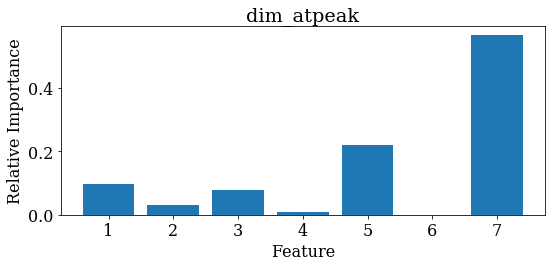

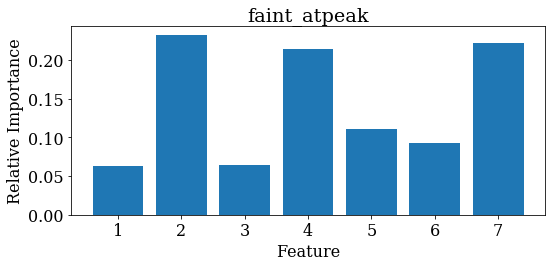

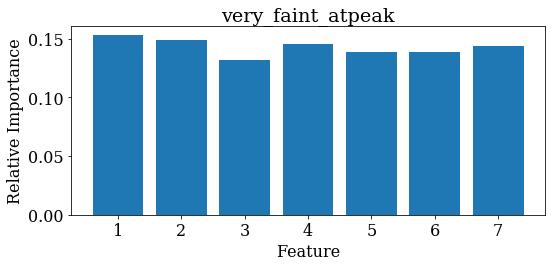

In [31]:
for sn_dir in fluxscaled_sne:
    clf = rf_classifiers[sn_dir]
    
    fig, ax = plt.subplots(1,1, figsize=(8,4))

    # Label line
    ax.bar(range(1,len(rf_features)+1), clf.feature_importances_)
    ax.set(xlabel='Feature',
           ylabel='Relative Importance',
           title=sn_dir)
    fig.tight_layout()

## Statistics vs. redshift

In [34]:
all_test_specs = {}

for sn_dir in spec_tables:
    spec_table = spec_tables[sn_dir]
    
    test_specs = spec_table[np.asarray(df['is_train']==False)]
    test_specs['PREDICTED'] = np.asarray(preds, dtype='|S6')
    test_specs.sort('REDSHIFT')
    
    for spec in test_specs:
        if spec['PREDICTED'] == '0.0':
            spec['PREDICTED'] = 'Galaxy'
        if spec['HAS_SN'] == False:
            spec['HAS_SN'] = 'Galaxy'
    
    all_test_specs[sn_dir] = test_specs

In [36]:
print list(all_test_specs['bright_atpeak']['HAS_SN'])[:8]
print list(all_test_specs['bright_atpeak']['PREDICTED'])[:8]

['Galaxy', 'Ia', 'Galaxy', 'Galaxy', 'Ia', 'Galaxy', 'Galaxy', 'Ia']
['Galaxy', 'Ia', 'Galaxy', 'Galaxy', 'Ia', 'Galaxy', 'Galaxy', 'Ia']


In [40]:
n_per_bin = 500
all_zbins = {}
all_zbin_stats = {}

for sn_dir in all_test_specs:
    test_specs = all_test_specs[sn_dir]
    test_specs_redshifts = np.asarray(test_specs['REDSHIFT'])
    
    zbins = []
    i = 0
    for zrange in test_specs_redshifts[::n_per_bin]:
        zbin = test_specs_redshifts[i: i + n_per_bin]
        zbins.append([zbin[0], zbin[-1]])
        i += n_per_bin
    
    all_zbins[sn_dir] = zbins
    
    zbin_stats = []
    for zbin in zbins:
        zcut = ((test_specs['REDSHIFT'] > zbin[0]) & 
                  (test_specs['REDSHIFT'] < zbin[1]))

        zbin_specs = test_specs[zcut]

        cm = ConfusionMatrix(np.asarray(zbin_specs['HAS_SN']),
                             np.asarray(zbin_specs['PREDICTED']))

        zbin_stats.append(cm)
    
    all_zbin_stats[sn_dir] = zbin_stats

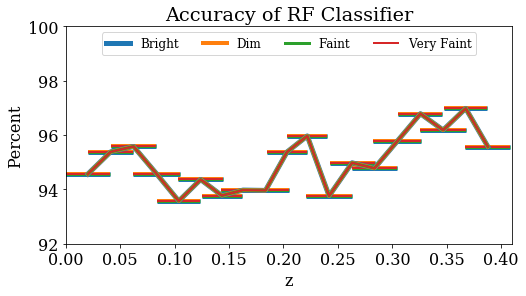

In [52]:
fig, ax = plt.subplots(1,1, figsize=(8,4))

labels = ['Bright', 'Dim', 'Faint', 'Very Faint']

for i, sn_dir in enumerate(fluxscaled_sne):
    zbin_stats = all_zbin_stats[sn_dir][:-1]
    zbins      = all_zbins[sn_dir][:-1]
    
    zbin_means = [(z[0]+z[1])/2. for z in zbins]
    zbinwidths = [z[1]-z[0] for z in zbins]
    
    # Get desired stats
    zbin_acc = np.array([cm.ACC for cm in zbin_stats])
#     zbin_TPR = np.array([cm.TPR for cm in zbin_stats])
#     zbin_TNR = np.array([cm.TNR for cm in zbin_stats])
#     zbin_FPR = np.array([cm.FPR for cm in zbin_stats])
#     zbin_FNR = np.array([cm.FNR for cm in zbin_stats])

    
    ax.errorbar(zbin_means, zbin_acc*100, xerr=zbinwidths, 
                lw=5-i, label=labels[i])
    
ax.set(xlabel='z', ylabel='Percent', title='Accuracy of RF Classifier',
       ylim=[92,100], 
       xlim=[0, 0.41])

ax.legend(loc='upper center', ncol=4, fontsize=12)